In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
import matplotlib.pyplot as plt

In [3]:
TrainPath = '/Users/michael/Documents/DAAN570/Group Project/Group Project Images/Training'
ValPath = '/Users/michael/Documents/DAAN570/Group Project/Group Project Images/Validation'

In [4]:
datagen_train = keras.preprocessing.image.ImageDataGenerator(
    rescale =1./255,
    validation_split=.2,
    rotation_range=20,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)

batch_size=64

train_generator = datagen_train.flow_from_directory(
    TrainPath,
    seed=39,
    target_size=(224,224),
    batch_size=batch_size,
    classes=['female','male'],
    class_mode='binary',
    shuffle=True
)

val_generator = datagen_train.flow_from_directory(
    ValPath,
    seed=39,
    target_size=(224,224),
    batch_size=batch_size,
    classes=['female','male'],
    class_mode='binary',
    shuffle=True,
)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [5]:
from matplotlib.image import imread

takeapeak = imread('/Users/michael/Documents/DAAN570/Group Project/Group Project Images/Training/female/131422.jpg.jpg'
)
takeapeak.shape

(114, 92, 3)

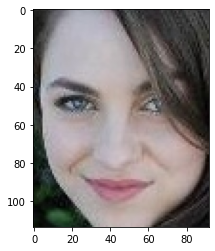

In [6]:
plt.imshow(takeapeak)

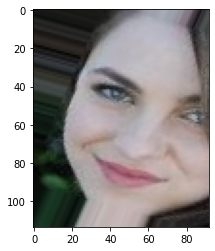

In [7]:
plt.imshow(datagen_train.random_transform(takeapeak))

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, concatenate

In [9]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [10]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(1, activation = 'sigmoid')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1, activation = 'sigmoid')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(1, activation = 'sigmoid')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model


In [11]:
model = GoogLeNet()

In [12]:
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 54, 54, 64)   0           ['conv2d[0][0]']                 
                                                                                          

                                                                                                  
 conv2d_24 (Conv2D)             (None, 12, 12, 224)  226016      ['conv2d_23[0][0]']              
                                                                                                  
 conv2d_26 (Conv2D)             (None, 12, 12, 64)   38464       ['conv2d_25[0][0]']              
                                                                                                  
 conv2d_27 (Conv2D)             (None, 12, 12, 64)   32832       ['max_pooling2d_6[0][0]']        
                                                                                                  
 concatenate_3 (Concatenate)    (None, 12, 12, 512)  0           ['conv2d_22[0][0]',              
                                                                  'conv2d_24[0][0]',              
                                                                  'conv2d_26[0][0]',              
          

 conv2d_51 (Conv2D)             (None, 5, 5, 128)    102528      ['conv2d_50[0][0]']              
                                                                                                  
 conv2d_52 (Conv2D)             (None, 5, 5, 128)    106624      ['max_pooling2d_11[0][0]']       
                                                                                                  
 concatenate_7 (Concatenate)    (None, 5, 5, 832)    0           ['conv2d_47[0][0]',              
                                                                  'conv2d_49[0][0]',              
                                                                  'conv2d_51[0][0]',              
                                                                  'conv2d_52[0][0]']              
                                                                                                  
 conv2d_54 (Conv2D)             (None, 5, 5, 192)    159936      ['concatenate_7[0][0]']          
          

In [13]:
from keras.utils import plot_model

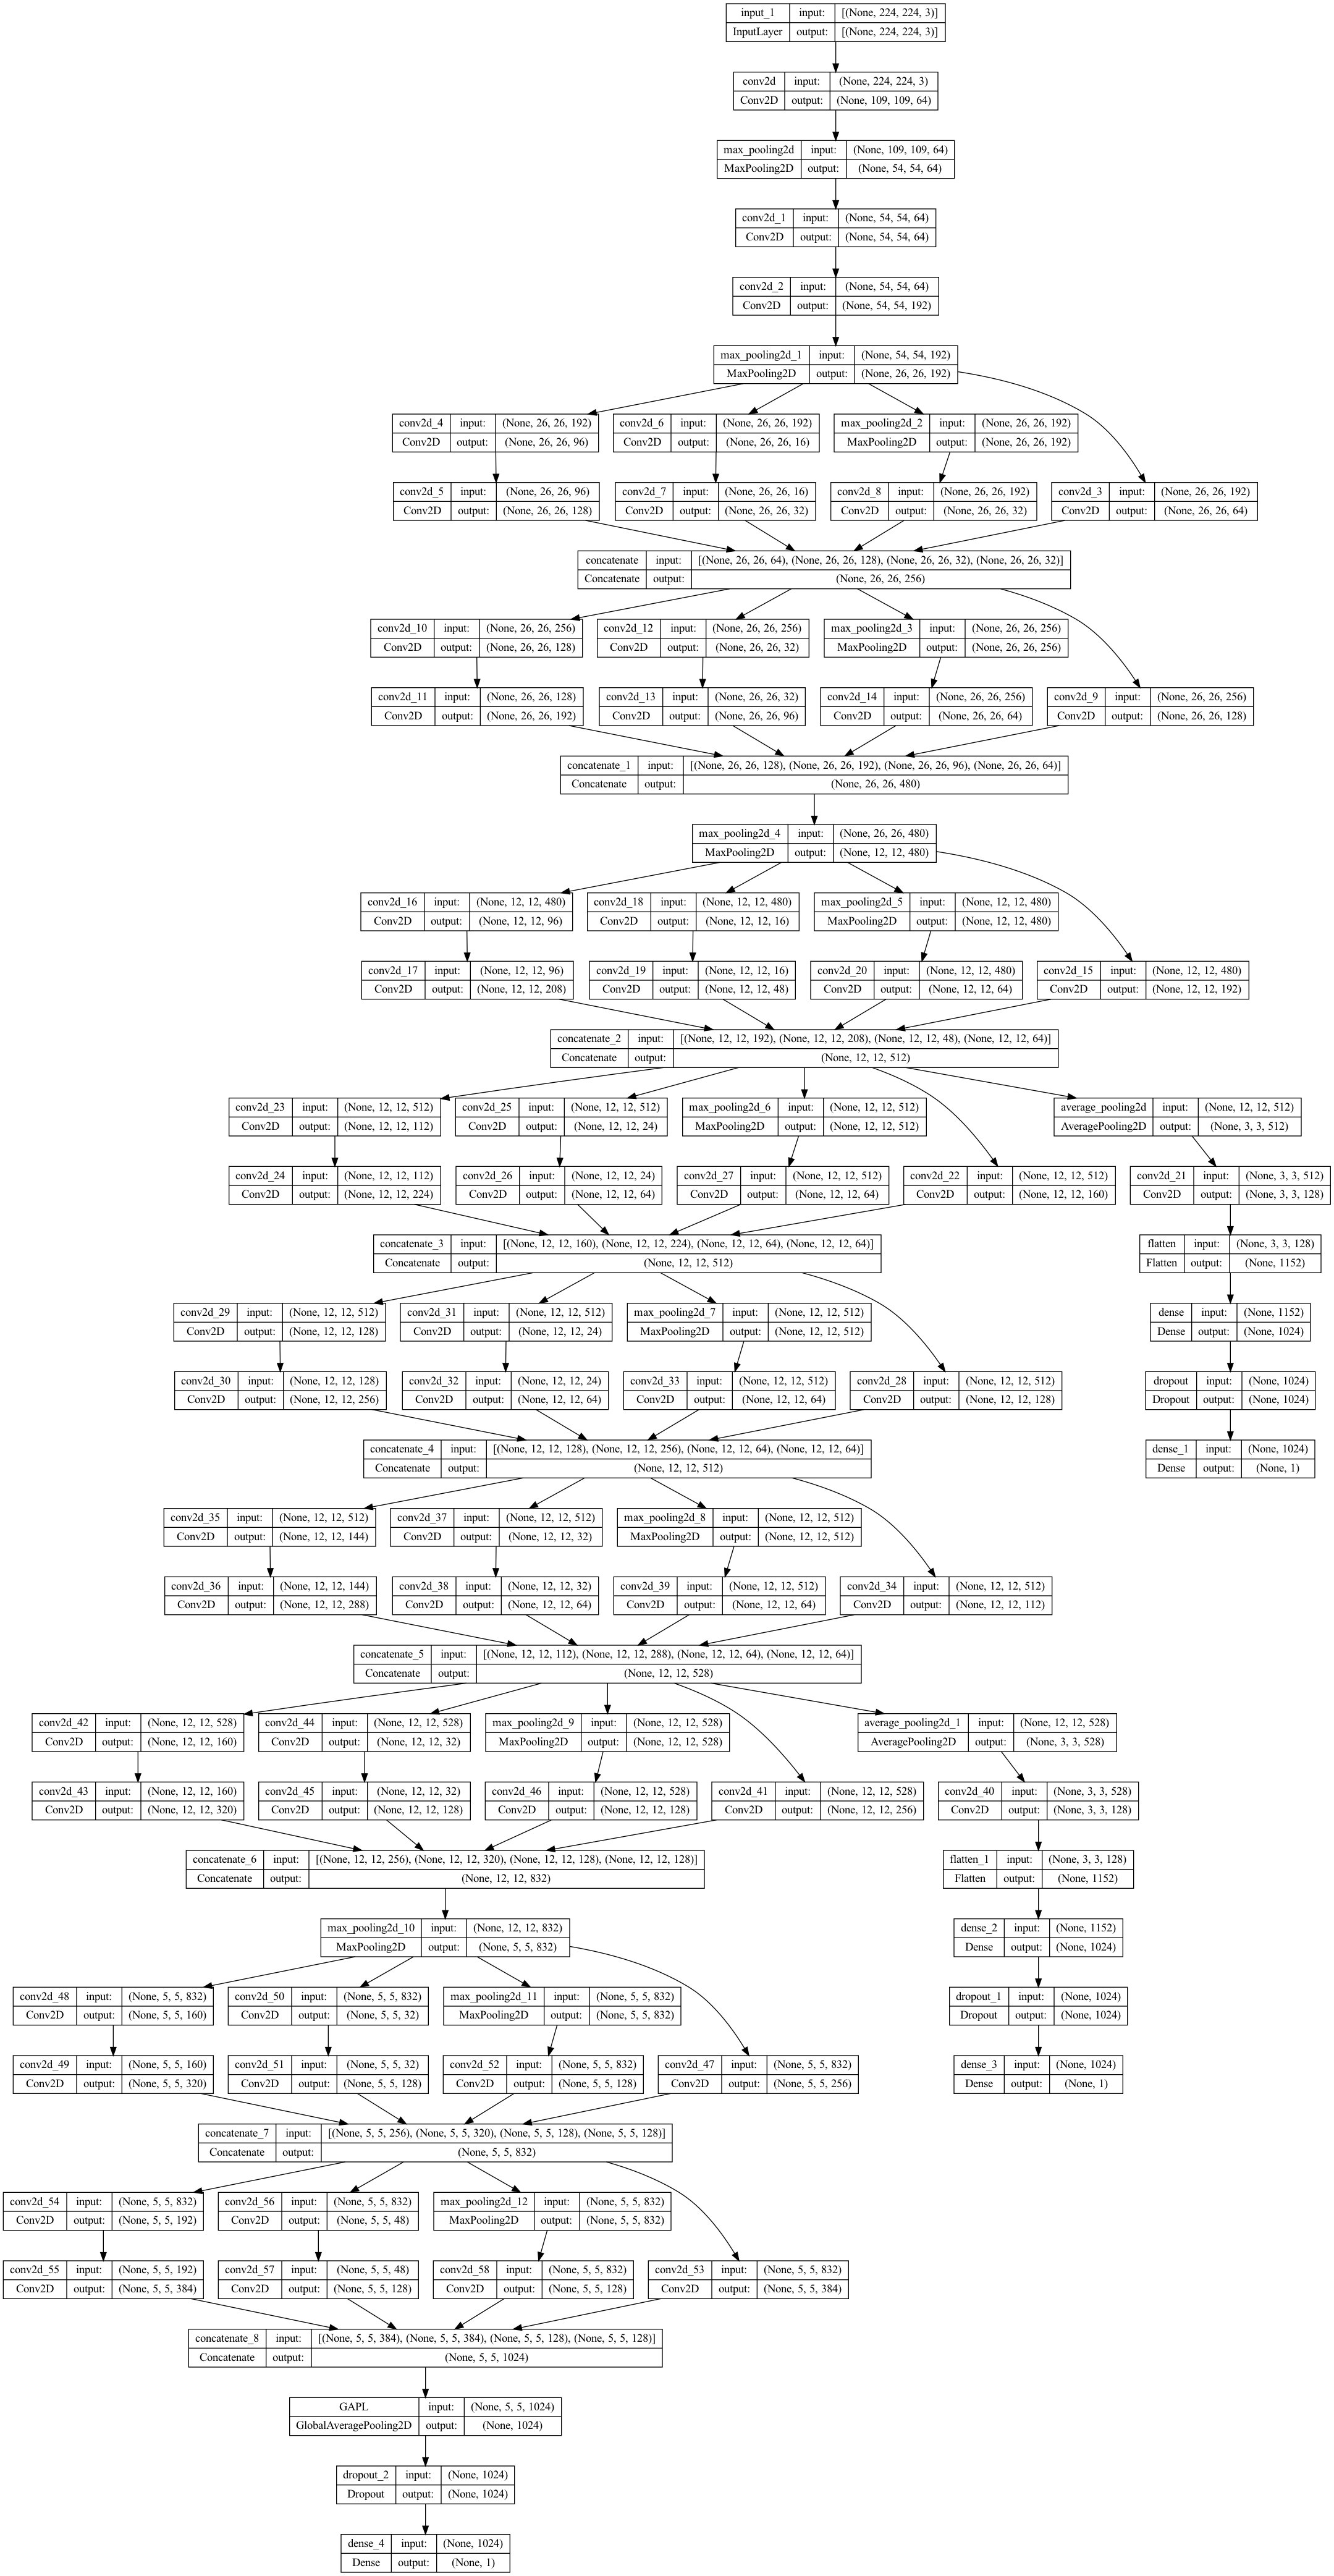

In [14]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [16]:
fit1 = model.fit(train_generator, validation_data=val_generator, validation_steps = val_generator.samples // batch_size,
                   epochs=20,
                   steps_per_epoch = train_generator.samples // batch_size)

Epoch 1/20
734/734 [==============================] - 854s 1s/step - loss: 2.0319 - dense_4_loss: 0.6722 - dense_1_loss: 0.6848 - dense_3_loss: 0.6749 - dense_4_accuracy: 0.5725 - dense_1_accuracy: 0.5622 - dense_3_accuracy: 0.5773 - val_loss: 1.9237 - val_dense_4_loss: 0.6244 - val_dense_1_loss: 0.6686 - val_dense_3_loss: 0.6306 - val_dense_4_accuracy: 0.6604 - val_dense_1_accuracy: 0.6065 - val_dense_3_accuracy: 0.6617
Epoch 2/20
734/734 [==============================] - 906s 1s/step - loss: 1.8632 - dense_4_loss: 0.6024 - dense_1_loss: 0.6538 - dense_3_loss: 0.6070 - dense_4_accuracy: 0.6758 - dense_1_accuracy: 0.6288 - dense_3_accuracy: 0.6739 - val_loss: 1.7420 - val_dense_4_loss: 0.5586 - val_dense_1_loss: 0.6290 - val_dense_3_loss: 0.5543 - val_dense_4_accuracy: 0.7140 - val_dense_1_accuracy: 0.6684 - val_dense_3_accuracy: 0.7246
Epoch 3/20
734/734 [==============================] - 960s 1s/step - loss: 1.6065 - dense_4_loss: 0.4943 - dense_1_loss: 0.6097 - dense_3_loss: 0.5025

734/734 [==============================] - 892s 1s/step - loss: 0.7126 - dense_4_loss: 0.2083 - dense_1_loss: 0.2863 - dense_3_loss: 0.2180 - dense_4_accuracy: 0.9189 - dense_1_accuracy: 0.8852 - dense_3_accuracy: 0.9155 - val_loss: 0.6537 - val_dense_4_loss: 0.1928 - val_dense_1_loss: 0.2627 - val_dense_3_loss: 0.1983 - val_dense_4_accuracy: 0.9275 - val_dense_1_accuracy: 0.8976 - val_dense_3_accuracy: 0.9262


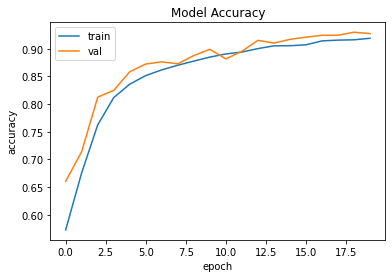

In [56]:
plt.plot(fit1.history['dense_4_accuracy'])
plt.plot(fit1.history['val_dense_4_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

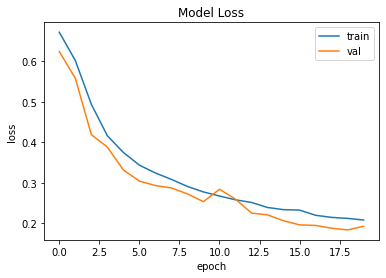

In [57]:
plt.plot(fit1.history['dense_4_loss'])
plt.plot(fit1.history['val_dense_4_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

In [17]:
def GoogLeNet2():
  # input layer 
  input_layer = Input(shape = (224, 224, 1))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(1, activation = 'sigmoid')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1, activation = 'sigmoid')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(1, activation = 'sigmoid')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [18]:
model2 = GoogLeNet2()

In [19]:
model2.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_59 (Conv2D)             (None, 109, 109, 64  3200        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 54, 54, 64)  0           ['conv2d_59[0][0]']              
 )                                                                                        

                                                                                                  
 conv2d_84 (Conv2D)             (None, 12, 12, 24)   12312       ['concatenate_11[0][0]']         
                                                                                                  
 max_pooling2d_19 (MaxPooling2D  (None, 12, 12, 512)  0          ['concatenate_11[0][0]']         
 )                                                                                                
                                                                                                  
 conv2d_81 (Conv2D)             (None, 12, 12, 160)  82080       ['concatenate_11[0][0]']         
                                                                                                  
 conv2d_83 (Conv2D)             (None, 12, 12, 224)  226016      ['conv2d_82[0][0]']              
                                                                                                  
 conv2d_85

                                                                                                  
 conv2d_109 (Conv2D)            (None, 5, 5, 32)     26656       ['max_pooling2d_23[0][0]']       
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 5, 5, 832)   0           ['max_pooling2d_23[0][0]']       
 )                                                                                                
                                                                                                  
 conv2d_106 (Conv2D)            (None, 5, 5, 256)    213248      ['max_pooling2d_23[0][0]']       
                                                                                                  
 conv2d_108 (Conv2D)            (None, 5, 5, 320)    461120      ['conv2d_107[0][0]']             
                                                                                                  
 conv2d_11

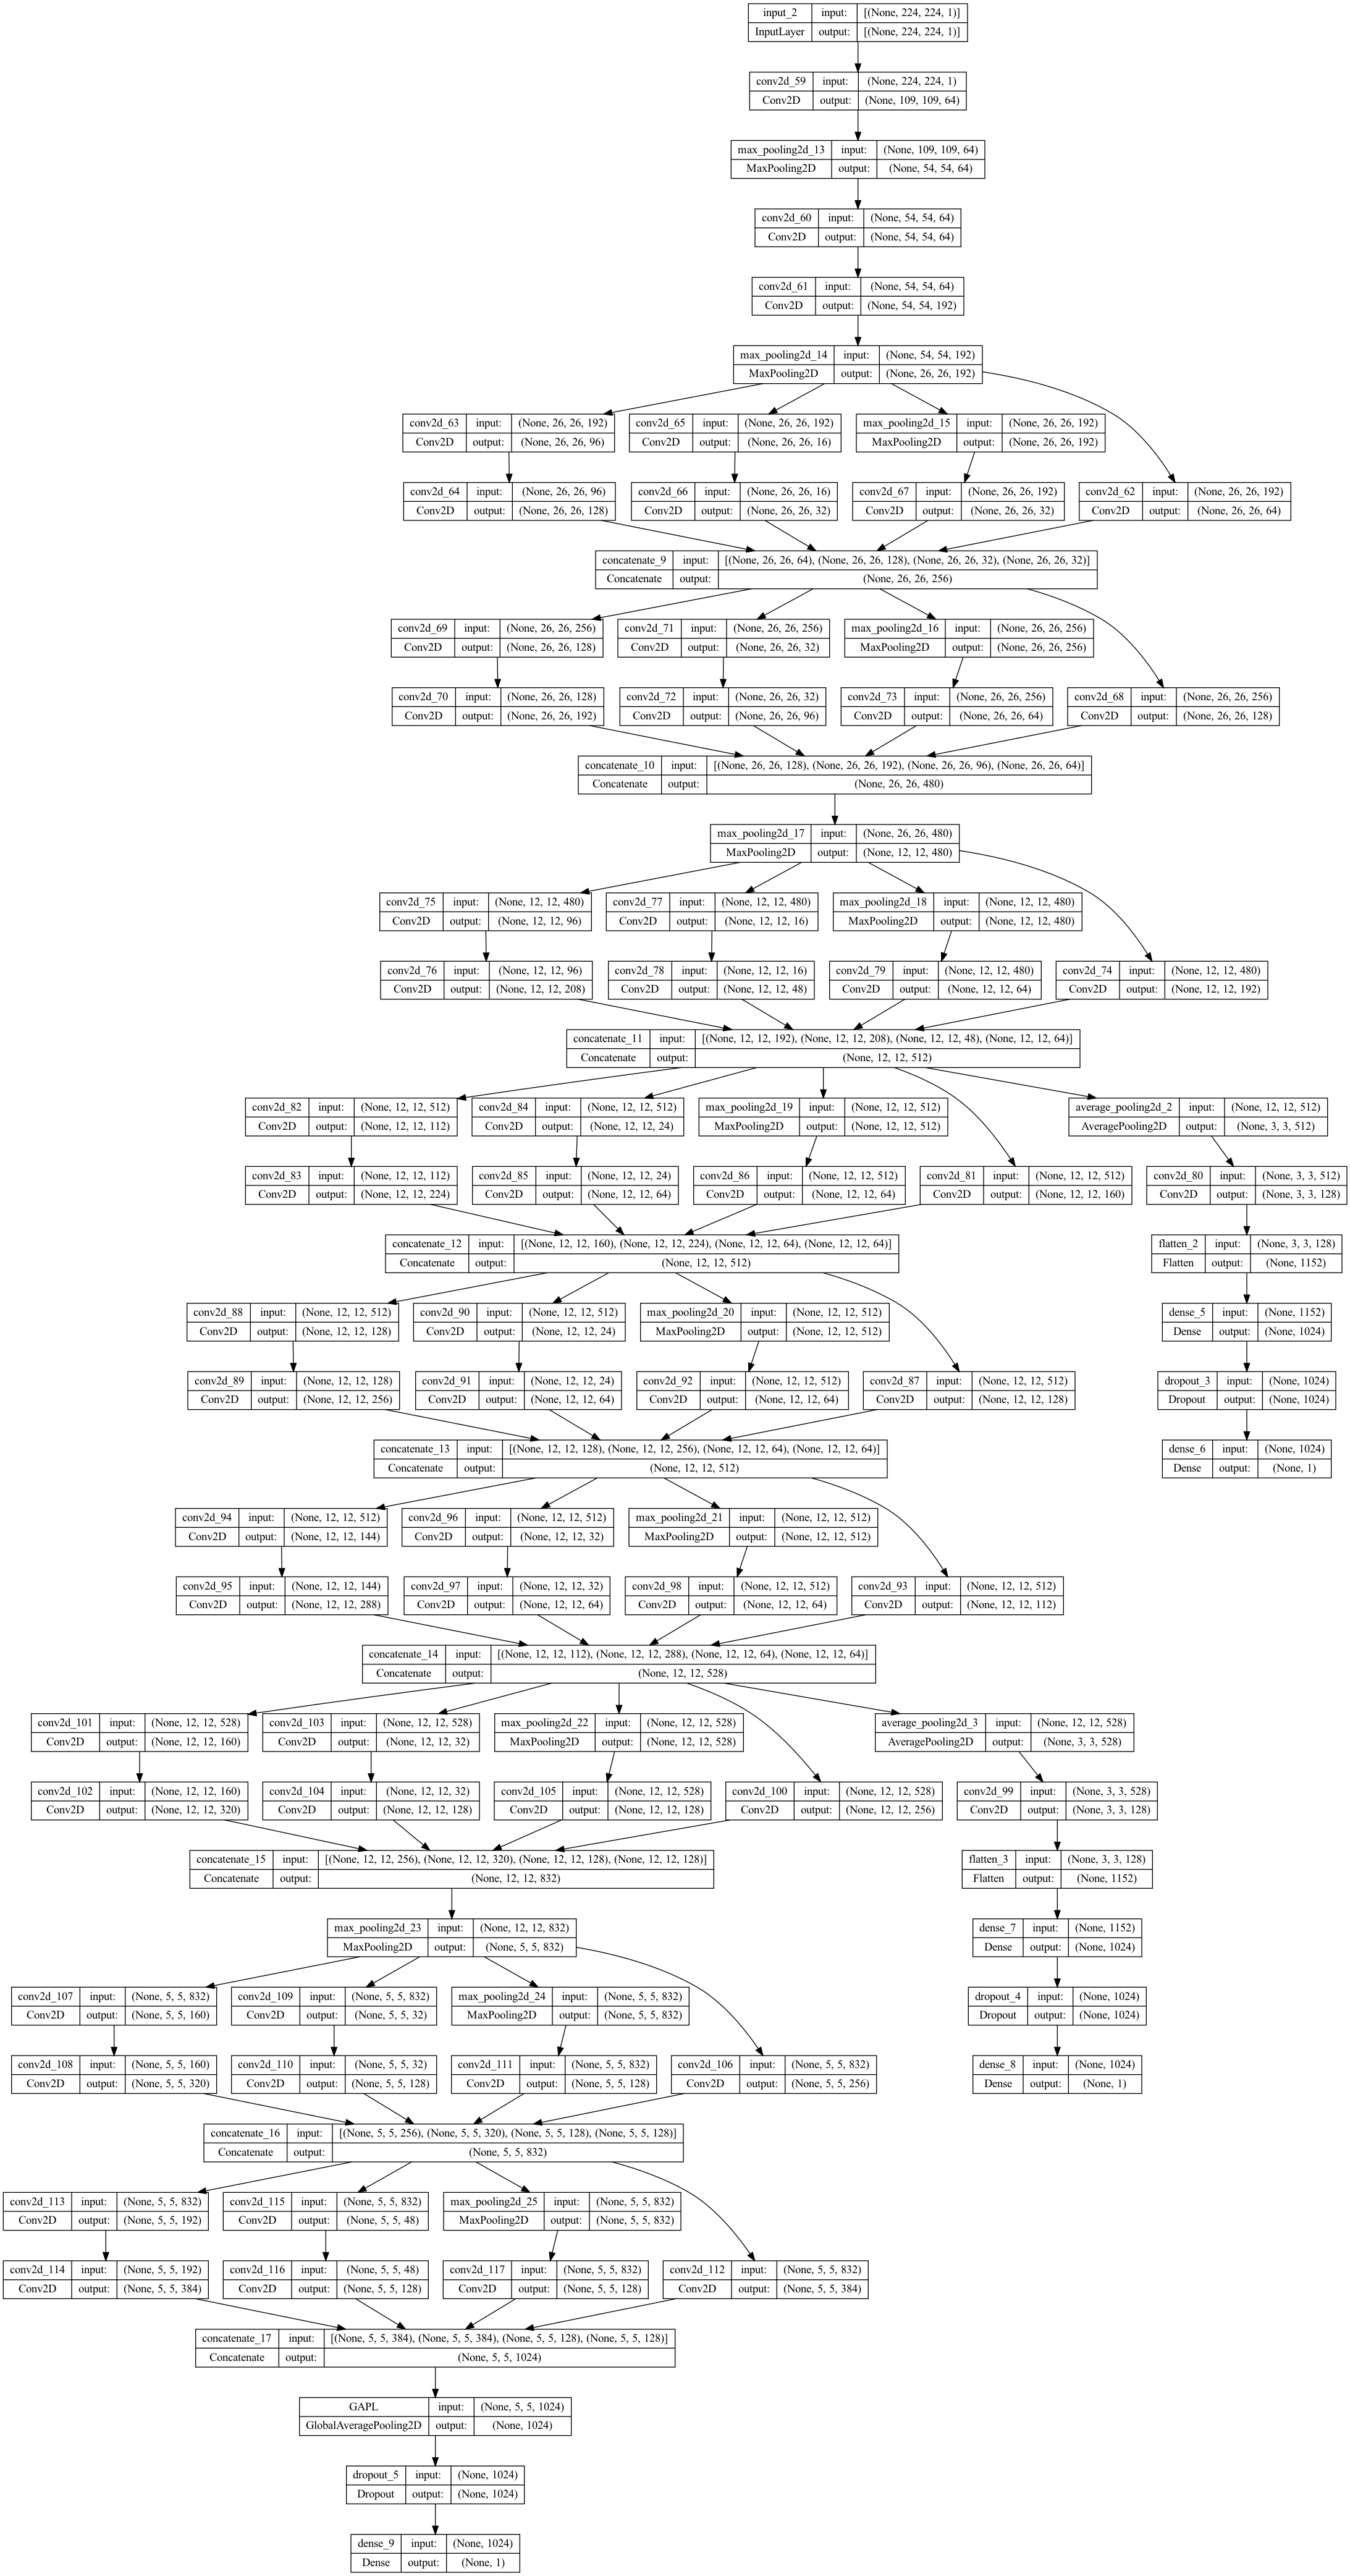

In [47]:
plot_model(model2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

In [20]:

train_generator_gray = datagen_train.flow_from_directory(
    TrainPath,
    seed=39,
    target_size=(224,224),
    color_mode='grayscale',
    batch_size=batch_size,
    classes=['female','male'],
    class_mode='binary',
    shuffle=True
)

val_generator_gray = datagen_train.flow_from_directory(
    ValPath,
    seed=39,
    target_size=(224,224),
    color_mode='grayscale',
    batch_size=batch_size,
    classes=['female','male'],
    class_mode='binary',
    shuffle=True,
)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [21]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [23]:
fit2 = model2.fit(train_generator_gray, validation_data=val_generator_gray, validation_steps = val_generator_gray.samples // batch_size,
                   epochs=20,
                   steps_per_epoch = train_generator_gray.samples // batch_size)

Epoch 1/20
734/734 [==============================] - 809s 1s/step - loss: 2.0524 - dense_9_loss: 0.6807 - dense_6_loss: 0.6899 - dense_8_loss: 0.6819 - dense_9_accuracy: 0.5482 - dense_6_accuracy: 0.5466 - dense_8_accuracy: 0.5549 - val_loss: 1.9813 - val_dense_9_loss: 0.6484 - val_dense_6_loss: 0.6813 - val_dense_8_loss: 0.6516 - val_dense_9_accuracy: 0.6244 - val_dense_6_accuracy: 0.6111 - val_dense_8_accuracy: 0.6211
Epoch 2/20
734/734 [==============================] - 838s 1s/step - loss: 1.9510 - dense_9_loss: 0.6394 - dense_6_loss: 0.6701 - dense_8_loss: 0.6414 - dense_9_accuracy: 0.6315 - dense_6_accuracy: 0.6042 - dense_8_accuracy: 0.6307 - val_loss: 1.8351 - val_dense_9_loss: 0.5831 - val_dense_6_loss: 0.6570 - val_dense_8_loss: 0.5950 - val_dense_9_accuracy: 0.7010 - val_dense_6_accuracy: 0.6215 - val_dense_8_accuracy: 0.6971
Epoch 3/20
734/734 [==============================] - 874s 1s/step - loss: 1.7621 - dense_9_loss: 0.5530 - dense_6_loss: 0.6445 - dense_8_loss: 0.5645

734/734 [==============================] - 910s 1s/step - loss: 0.8116 - dense_9_loss: 0.2339 - dense_6_loss: 0.3331 - dense_8_loss: 0.2446 - dense_9_accuracy: 0.9088 - dense_6_accuracy: 0.8650 - dense_8_accuracy: 0.9051 - val_loss: 0.9072 - val_dense_9_loss: 0.2888 - val_dense_6_loss: 0.3246 - val_dense_8_loss: 0.2938 - val_dense_9_accuracy: 0.8776 - val_dense_6_accuracy: 0.8663 - val_dense_8_accuracy: 0.8735


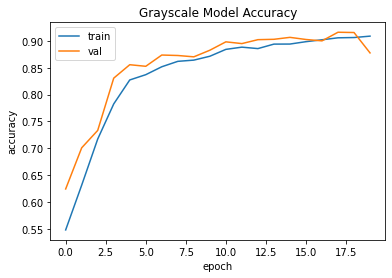

In [55]:
plt.plot(fit2.history['dense_9_accuracy'])
plt.plot(fit2.history['val_dense_9_accuracy'])
plt.title('Grayscale Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

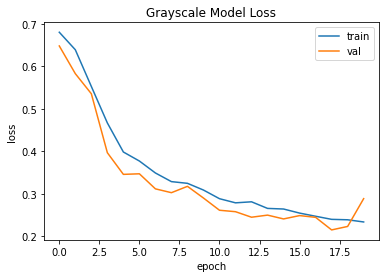

In [54]:
plt.plot(fit2.history['dense_9_loss'])
plt.plot(fit2.history['val_dense_9_loss'])
plt.title('Grayscale Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

In [24]:
from tqdm.notebook import tqdm
import os

In [25]:
BASE_DIR = '/Users/michael/Documents/DAAN570/Group Project/UTKFace/utkface_aligned_cropped/UTKFace'

In [26]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [27]:
#Visualize data by pandas
image_paths = pd.Series(list(image_paths), name = 'Images Path')
age_labels = pd.Series(list(age_labels), name = 'Ages')
gender_labels = pd.Series(list(gender_labels), name = 'Genders')

UTKdataframe = pd.concat([image_paths, age_labels, gender_labels], axis = 1)
UTKdataframe

,Images Path,Ages,Genders
0,/Users/michael/Documents/DAAN570/Group Project...,9,1
1,/Users/michael/Documents/DAAN570/Group Project...,36,0
2,/Users/michael/Documents/DAAN570/Group Project...,86,1
3,/Users/michael/Documents/DAAN570/Group Project...,26,1
4,/Users/michael/Documents/DAAN570/Group Project...,1,1
...,...,...,...
23703,/Users/michael/Documents/DAAN570/Group Project...,35,0
23704,/Users/michael/Documents/DAAN570/Group Project...,52,0
23705,/Users/michael/Documents/DAAN570/Group Project...,26,0
23706,/Users/michael/Documents/DAAN570/Group Project...,28,0


In [28]:
UTKdataframe['Genders'] = np.logical_not(UTKdataframe['Genders']).astype(int)
UTKdataframe
#Match UTK genders formatting with previous models

,Images Path,Ages,Genders
0,/Users/michael/Documents/DAAN570/Group Project...,9,0
1,/Users/michael/Documents/DAAN570/Group Project...,36,1
2,/Users/michael/Documents/DAAN570/Group Project...,86,0
3,/Users/michael/Documents/DAAN570/Group Project...,26,0
4,/Users/michael/Documents/DAAN570/Group Project...,1,0
...,...,...,...
23703,/Users/michael/Documents/DAAN570/Group Project...,35,1
23704,/Users/michael/Documents/DAAN570/Group Project...,52,1
23705,/Users/michael/Documents/DAAN570/Group Project...,26,1
23706,/Users/michael/Documents/DAAN570/Group Project...,28,1


In [30]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

In [29]:
gender_dict = {0:'female', 1:'male'}
#how the pictures are named

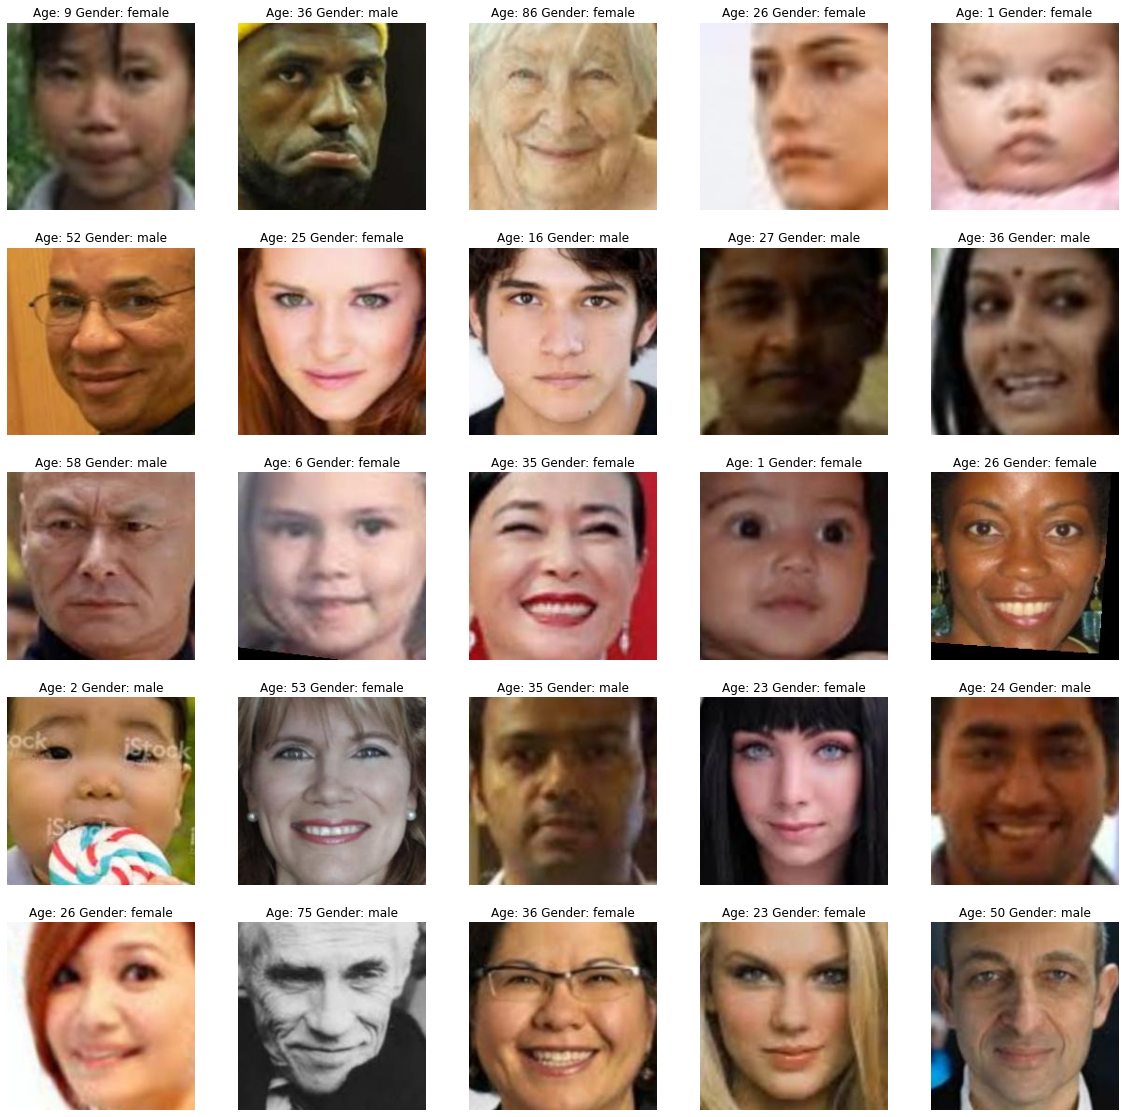

In [31]:
plt.figure(figsize=(20, 20))
files = UTKdataframe.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [32]:
from tqdm import tqdm
from PIL import Image, ImageOps

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=False)
        img = img.resize((224, 224), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    #features = features.reshape(len(features), 128, 128, 3)
    return features

In [33]:
X = extract_features(UTKdataframe['Images Path'])

  0%|          | 0/23708 [00:00<?, ?it/s]<ipython-input-32-5230771b39d0>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)
100%|██████████| 23708/23708 [00:29<00:00, 796.61it/s]


In [34]:
X.shape

(23708, 224, 224, 3)

In [35]:
y_gender = np.array(UTKdataframe['Genders'])
y_gender = np.asarray(y_gender).astype('float32').reshape((-1,1))

In [36]:
y_gender.shape

(23708, 1)

In [37]:
RGBUTKscore = model.evaluate(X, y_gender, verbose=0)

In [38]:
RGBUTKscore

[189.2421112060547,
 55.638526916503906,
 77.0775375366211,
 56.52605056762695,
 0.7819722890853882,
 0.7682216763496399,
 0.7891850471496582]

In [151]:
RGBUTK_Pred = model.predict(X)

741/741 [==============================] - 91s 122ms/step


In [153]:
rgb_y_pred = np.round(RGBUTK_Pred[0])

In [157]:
from sklearn.metrics import confusion_matrix

In [158]:
confusion_matrix(y_gender, rgb_y_pred)

array([[ 7592,  3725],
       [ 1444, 10947]])

In [39]:
def grayscale_extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((224, 224), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    
    features = features.reshape(len(features), 224, 224, 1)
    return features

In [40]:
X2 = grayscale_extract_features(UTKdataframe['Images Path'])

  0%|          | 0/23708 [00:00<?, ?it/s]/Users/michael/miniforge3/envs/mlp/lib/python3.9/site-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
<ipython-input-39-7cc72125b02c>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)
100%|██████████| 23708/23708 [00:19<00:00, 1210.67it/s]


In [41]:
X2.shape

(23708, 224, 224, 1)

In [42]:
GSUTKscore = model2.evaluate(X2, y_gender, verbose=0)

In [49]:
GSUTKscore

[251.42137145996094,
 61.16611862182617,
 94.0947265625,
 96.16043090820312,
 0.6340053677558899,
 0.6650075912475586,
 0.621309220790863]

In [159]:
GSUTK_Pred = model2.predict(X2)

741/741 [==============================] - 88s 102ms/step


In [162]:
gs_y_pred = np.round(GSUTK_Pred[0])

In [163]:
confusion_matrix(y_gender, gs_y_pred)

array([[10687,   630],
       [ 8047,  4344]])